https://towardsdatascience.com/walking-through-support-vector-regression-and-lstms-with-stock-price-prediction-45e11b620650

https://github.com/kartik-joshi/Stock-predection

### Import libs

In [1]:
import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')

It seems that when we train the model on only more recent data, we get a much better prediction. See the marked line below to comment/uncomment to see the changes in our results.

In [40]:
df = pd.read_csv('./data_clean/TSLA.csv')
df = df.sort_values('date')
# df = df.drop(['open','high','low','close','volume'], axis=1)
df = df.drop(['high','low','close','volume'], axis=1)

df = df.query('date <= "2019-10-01"') # <---------- this line
df = df.reset_index(drop=True)

In [41]:
df['momentum'] = 0
df['volatility'] = 0.0
df['adj_close_avg'] = 0.0

In [42]:
for i, _ in df.iterrows():
    if i > 1:
        df['momentum'][i] = 1 if df['adj close'][i - 1] > df['adj close'][i - 2] else -1
        df['volatility'][i] = df['adj close'][i - 1] / df['adj close'][i - 2]
    if i > 4:
        df['adj_close_avg'][i] = sum(df['adj close'][i] for i in range(i - 5, i)) / 5

### Check data

In [43]:
df.head(n=15)

,date,open,adj close,momentum,volatility,adj_close_avg
0,2015-01-02,222.869995,219.309998,0,0.000000,0.000000
1,2015-01-05,214.550003,210.089996,0,0.000000,0.000000
2,2015-01-06,210.059998,211.279999,-1,0.957959,0.000000
3,2015-01-07,213.350006,210.949997,1,1.005664,0.000000
4,2015-01-08,212.809998,210.619995,-1,0.998438,0.000000
5,2015-01-09,208.919998,206.660004,-1,0.998436,212.449997
6,2015-01-12,203.050003,202.210007,-1,0.981198,209.919998
7,2015-01-13,203.320007,204.250000,-1,0.978467,208.344000
8,2015-01-14,185.830002,192.690002,1,1.010088,206.938000
9,2015-01-15,194.490005,191.869995,-1,0.943403,203.286002


In [44]:
df.describe()

,open,adj close,momentum,volatility,adj_close_avg
count,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000
mean,265.843406,265.875222,-0.002510,0.998798,264.909840
std,54.554295,54.546312,0.999578,0.049615,56.726969
min,142.320007,143.669998,-1.000000,0.000000,0.000000
25%,220.229996,219.614998,-1.000000,0.986183,220.328999
50%,255.000000,254.860001,-1.000000,0.999911,253.546002
75%,313.115005,312.720001,1.000000,1.016213,314.073999
max,386.690002,385.000000,1.000000,1.173471,378.437994


In [45]:
print('Dimension of data:', df.shape)

Dimension of data: (1195, 6)


### Plot Data

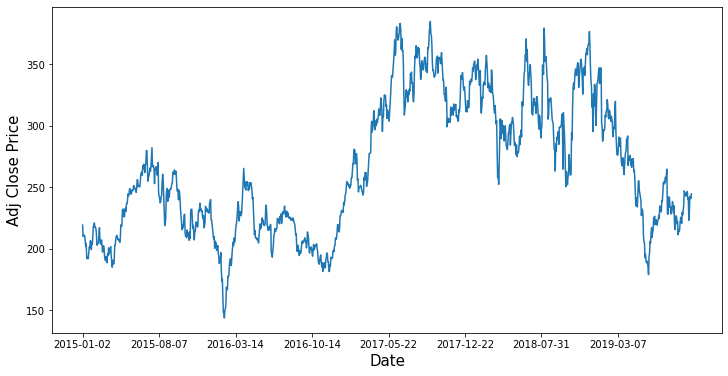

In [46]:
def plotStocks(data, dates, xticks, legend=False):
    plt.figure(figsize=(12,6))
    for datum in data:
        plt.plot(datum[0], datum[1], **datum[2])
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Adj Close Price', fontsize=15)
    plt.xticks(np.arange(0, len(dates), xticks))
    plt.legend() if legend else None
    plt.show()

stock_data = [(df['date'], df['adj close'], {})]
plotStocks(stock_data, df['date'], 150)

### Create feature set and target vector

In [47]:
X = df.drop(labels=['adj close'], axis=1)
y = df['adj close']

print('Dimension of feature matrix:', X.shape)
print('Dimension of target vector:', y.shape)

Dimension of feature matrix: (1195, 5)
Dimension of target vector: (1195,)


### Create test and train datasets

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

dates = X_test['date']
X_train = X_train.drop(labels=['date'], axis=1)
X_test = X_test.drop(labels=['date'], axis=1)

### Train Model

#### SVM regression

In [49]:
# SVM hyperparameter tuning - takes a long time to run
# param_grid = {'kernel': ('linear','poly','rbf','sigmoid'),
#               'C': [1,5,10],
#               'degree': [3,8],
#               'coef0': [0.01,10,0.5],
#               'gamma': ('auto','scale')}
# svr = SVR()
# grids = GridSearchCV(svr, param_grid, scoring='precision', cv=5, verbose=10)
# grids.fit(X_train, y_train)
# params_optimal = grids.best_params_
# svr = SVR(params_optimal)
# y_pred = svr.fit(X_train, y_train).predict(X_test)


# Uncomment below
# svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
# y_pred = svr.fit(X_train, y_train).predict(X_test)

# svm_confidence = svr.score(X_test, y_test)
# print('SVM Confidence:', svm_confidence)

#### Random forests regression

In [50]:
reg = RandomForestRegressor()
y_pred = reg.fit(X_train, y_train).predict(X_test)

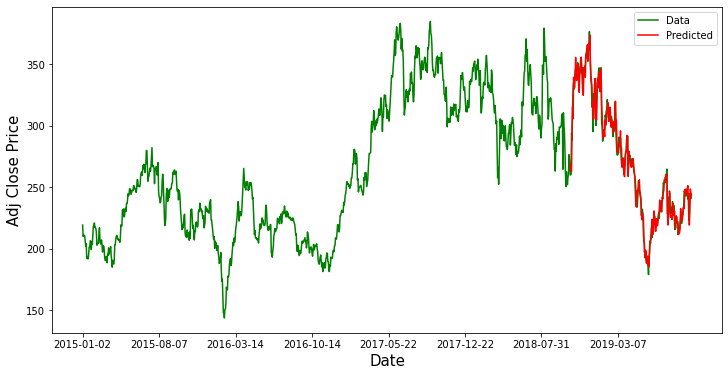

In [51]:
stock_data = [(df['date'], df['adj close'], {'color': 'green', 'label': 'Data'}),
              (dates, y_pred, {'color': 'red', 'label': 'Predicted'})]
plotStocks(stock_data, df['date'], 150, True)

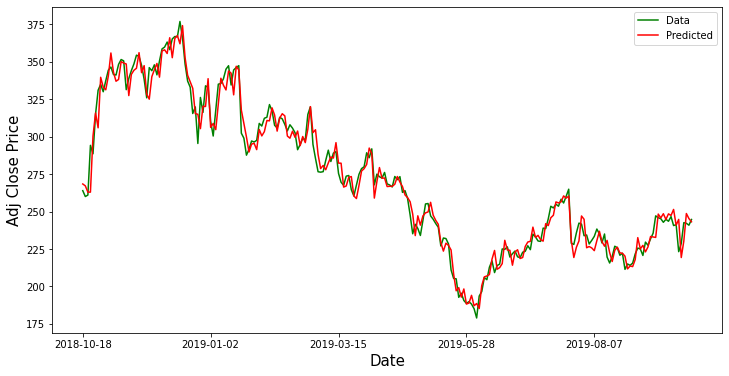

In [52]:
stock_data = [(dates, y_test, {'color': 'green', 'label': 'Data'}),
              (dates, y_pred, {'color': 'red', 'label': 'Predicted'})]
plotStocks(stock_data, dates, 50, True)

In [53]:
# reg = RandomForestRegressor()

# n = len(X_test)
# to_pred = pd.DataFrame(data=[[0,0.0,0.0]], columns=['momentum', 'volatility', 'adj_close_avg'])
# y_pred = np.array([])

# data = X_train.copy(deep=True)
# prices = y_train.copy(deep=True).to_numpy()

# def prepNextInstance(to_pred, prices, l):
#     to_pred['momentum'][0] = 1 if prices[l - 1] > prices[l - 2] else -1
#     to_pred['volatility'][0] = prices[l - 1] / prices[l - 2]
#     to_pred['adj_close_avg'][0] = sum(prices[i] for i in range(l - 5, l)) / 5

# for _ in range(n):
#     prepNextInstance(to_pred, prices, len(prices))
#     val = reg.fit(data, prices).predict(to_pred)
#     data = data.append(to_pred)
#     y_pred = np.append(y_pred, val)
#     prices = np.append(prices, val)

In [54]:
# stock_data = [(dates, y_test, {'color': 'green', 'label': 'Data'}),
#               (dates, y_pred, {'color': 'red', 'label': 'Predicted'})]
# plotStocks(stock_data, dates, 50, True)

### Evaluate Model

In [17]:
# matrix = confusion_matrix(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print('Confusion Matrix:\n', matrix)
# print('Precision: %f' % precision)
# print('Recall: %f' % recall)
# print('F1 Score: %f' % f1)